In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pandas import Series, DataFrame, read_csv
from scipy.integrate import solve_ivp
from labellines import labelLine, labelLines

In [2]:
%matplotlib notebook

In [3]:
g = 9.8 # m / s2
R = 8.314 # J / mol K

In [4]:
substance_data = read_csv("res/substance_data.csv").set_index("Name")

def _as_substance_series(a, **kwargs):
    return Series(a, index=substance_data.index, **kwargs)

In [5]:
reaction_data = read_csv("res/reaction_data_galan.csv").set_index("Reaction")

def _convert(df, src, dst, factor):
    _df = df
    if src in df.columns:
        _df[dst] = _df[src] * factor
    return _df

reaction_data = _convert(reaction_data, "A(Lmol-1s-1)", "A", 1)
reaction_data = _convert(reaction_data, "Ainv(Lmol-1s-1)", "Ainv", 1)
reaction_data = _convert(reaction_data, "Ea(cal/mol)", "Ea", 4.184)
reaction_data = _convert(reaction_data, "Eainv(cal/mol)", "Eainv", 4.184)

_Hf = substance_data["Hf(J/mol)"]

def _hstd(r, p):
    return np.sum([v * H for v, H in p]) - np.sum([v * H for v, H in r])

reaction_data.loc[1, "Hstd"] = _hstd(
    [(1, _Hf["Glycerol"]), (1, _Hf["Acetic Acid"])],
    [(1, _Hf["Monoacetin"]), (1, _Hf["Water"])]
)

reaction_data.loc[2, "Hstd"] = _hstd(
    [(1, _Hf["Monoacetin"]), (1, _Hf["Acetic Acid"])],
    [(1, _Hf["Diacetin"]), (1, _Hf["Water"])]
)

reaction_data.loc[3, "Hstd"] = _hstd(
    [(1, _Hf["Diacetin"]), (1, _Hf["Acetic Acid"])],
    [(1, _Hf["Triacetin"]), (1, _Hf["Water"])]
)

def _as_reaction_series(a, **kwargs):
    return Series(a, index=reaction_data.index, **kwargs)

reaction_data

,A(Lmol-1s-1),Ea(cal/mol),Ainv(Lmol-1s-1),Eainv(cal/mol),A,Ainv,Ea,Eainv,Hstd
Reaction,,,,,,,,,
1,0.000524,616.8,0.000856,-3864.4,0.000524,0.000856,2580.6912,-16168.6496,-36240.0
2,0.000097,-1462.3,216.000000,8701.1,0.000097,216.000000,-6118.2632,36405.4024,-19480.0
3,0.062600,4964.1,1.860000,5137.5,0.062600,1.860000,20769.7944,21495.3000,-12410.0


In [6]:
reaction_rate_table = _as_reaction_series(None, dtype="object")

def _arrhenius(A, Ea, T):
    return A * np.exp(-Ea / (R * T))


def _create_reaction_rate_function(j, l):
    def _f(C, T):
        s = _as_substance_series(C)
        
        A = reaction_data.loc[j, "A"]
        Ea = reaction_data.loc[j, "Ea"]
        k = _arrhenius(A, Ea, T)
        
        Ainv = reaction_data.loc[j, "Ainv"]
        Eainv = reaction_data.loc[j, "Eainv"]
        kinv = _arrhenius(Ainv, Eainv, T)
        
        a, b, c, d = (s[l[i]] for i in range(0, 4))
        
        return -k * a * b + kinv * c * d
    return _f
    

reaction_rate_table[1] = _create_reaction_rate_function(
    1, ["Glycerol", "Acetic Acid", "Monoacetin", "Water"]
)

reaction_rate_table[2] = _create_reaction_rate_function(
    2, ["Monoacetin", "Acetic Acid", "Diacetin", "Water"]
)

reaction_rate_table[3] = _create_reaction_rate_function(
    3, ["Diacetin", "Acetic Acid", "Triacetin", "Water"]
)

reaction_rate_table

Reaction
1    <function _create_reaction_rate_function.<loca...
2    <function _create_reaction_rate_function.<loca...
3    <function _create_reaction_rate_function.<loca...
dtype: object

In [7]:
net_reaction_rate_table = _as_substance_series(None, dtype="object")

def _create_net_reaction_rate_function(f):
    def _f(C, T, r=reaction_rate_table):
        return f(C, T, r)
    return _f

net_reaction_rate_table["Glycerol"] = _create_net_reaction_rate_function(
    lambda C, T, r: r[1](C, T) 
)

net_reaction_rate_table["Acetic Acid"] = _create_net_reaction_rate_function(
    lambda C, T, r: r[1](C, T) + r[2](C, T) + r[3](C, T)
)

net_reaction_rate_table["Water"] = _create_net_reaction_rate_function(
    lambda C, T, r: -r[1](C, T) - r[2](C, T) - r[3](C, T)
)

net_reaction_rate_table["Triacetin"] = _create_net_reaction_rate_function(
    lambda C, T, r: -r[3](C, T)
)

net_reaction_rate_table["Diacetin"] = _create_net_reaction_rate_function(
    lambda C, T, r: -r[2](C, T) + r[3](C, T)
)

net_reaction_rate_table["Monoacetin"] = _create_net_reaction_rate_function(
    lambda C, T, r: -r[1](C, T) + r[2](C, T)
)

net_reaction_rate_table

Name
Glycerol       <function _create_net_reaction_rate_function.<...
Acetic Acid    <function _create_net_reaction_rate_function.<...
Water          <function _create_net_reaction_rate_function.<...
Triacetin      <function _create_net_reaction_rate_function.<...
Diacetin       <function _create_net_reaction_rate_function.<...
Monoacetin     <function _create_net_reaction_rate_function.<...
dtype: object

In [8]:
def evaluate_reaction_rates(C, T):
    # C: (L/mol), T: (K), return: (mol/Ls)
     return _as_reaction_series([r(C, T) for r in reaction_rate_table])


def evaluate_net_reaction_rates(C, T):
    # C: (L/mol), T: (K), return: (mol/Ls)
    return _as_substance_series([r(C, T) for r in net_reaction_rate_table])


def evaluate_temperature_rate(v, F, T, Ta, D, U):
    # v: (L/s), F: (mol/s), T: (K), Ta: (K), D: (m),  U: (W/m2K), return: (K/m)
    _U = U / 100 # W/dm2K
    _D = D * 10 # dm
    At = np.pi * _D * _D / 4 # dm2
    r = evaluate_reaction_rates(F / v, T)
    
    # this works because the acetic acid has v=-1 in all reactions
    _1 = _U * 4 / _D * (Ta - T)
    _2 = np.sum([-rij * -Hrxnij for rij, Hrxnij in zip(r, reaction_data["Hstd"])])
    _3 = np.sum([Fi * Cpi for Fi, Cpi in zip(F, substance_data["Cp(J/molK)"])])
    
    return (_1 + _2) / _3 * At


def _as_objective_function_series(parameters):
    index = substance_data.index.union(["T"], sort=False)
    return Series(parameters, index=index)


def _unpack_objective_function_vector(vector):
    s = _as_objective_function_series(vector)
    return s.loc(axis=0)[substance_data.index], s["T"]


def _create_objective_function(v0, F0, Ta, D, U):
    def objective_function(L, vector):
        F, T = _unpack_objective_function_vector(vector)
        _r = evaluate_net_reaction_rates(F / v0, T)
        _T = evaluate_temperature_rate(v0, F, T, Ta, D, U)
        return np.concatenate((_r, [_T]))
    return objective_function


def _estimate_density(F):
    return np.average(substance_data["p(kg/m3)"])


def _bernoulli_pressure_drop(F, L):
    p = _estimate_density(F)
    return p * g * L * 9.86923e-6


def _estimate_volumetric_flow(F):
    s = _as_substance_series(F) # mol / s
    w = substance_data["MW(g/mol)"] * s / 1000 # kg / mol
    return np.sum(w / substance_data["p(kg/m3)"]) * 1000 # L / s


def solve(**kwargs):
    F0 = kwargs.pop("F0") # mol / s
    T0 = kwargs.pop("T0") # K
    P0 = kwargs.pop("P0") # atm
    Ta = kwargs.pop("Ta") # K
    D = kwargs.pop("D") # m
    U = kwargs.pop("U") # U
    L = kwargs.pop("L") # m
    v0 = _estimate_volumetric_flow(F0) # L / s
    
    # create the objective function
    _f = _create_objective_function(v0, F0, Ta, D, U)
    
    _L = L * 10 # dm
    
    # solve with RK45
    r = solve_ivp(_f, [0, _L], np.concatenate((F0, [T0])), **kwargs)
    
    index = r.t / 10
    
    # create the molar flows dataframe
    F = DataFrame(r.y[:-1].transpose(), index=index, columns=substance_data.index.to_numpy())
    
    # create a temperature series
    T = Series(r.y[-1], index=index, name="T")
    
    pressure_drop = np.vectorize(lambda L: _bernoulli_pressure_drop(F0, L))
    
    # create a pressure series
    P = Series(P0 - pressure_drop(index), index=index, name="L")
    
    # evaluate a reaction rate series
    r = [evaluate_net_reaction_rates(f, t).to_numpy() for f, t in zip(F.to_numpy(), T.to_numpy())]
    r =  DataFrame(r, index=index, columns=substance_data.index.to_numpy())
    
    return F, T, P, r

In [9]:
F400, T400, P400, r400 = solve(
    F0 = [0.1, 1.6, 0, 0, 0, 0], # mol / s
    T0 = 400, # K
    P0 = 10, # atm
    Ta = 298.15, # K
    D = 1 * 2.54 / 100, # m
    U = 5, # W / m2 C
    L = 20, # m
    max_step=1
)

F420, T420, P420, r420 = solve(
    F0 = [0.1, 1.6, 0, 0, 0, 0], # mol / s
    T0 = 420, # K
    P0 = 10, # atm
    Ta = 298.15, # K
    D = 1 * 2.54 / 100, # m
    U = 5, # W / m2 C
    L = 20, # m
    max_step=1
)

F380, T380, P380, r380 = solve(
    F0 = [0.1, 1.6, 0, 0, 0, 0], # mol / s
    T0 = 380, # K
    P0 = 10, # atm
    Ta = 298.15, # K
    D = 1 * 2.54 / 100, # m
    U = 5, # W / m2 C
    L = 20, # m
    max_step=1
)

<IPython.core.display.Javascript object>


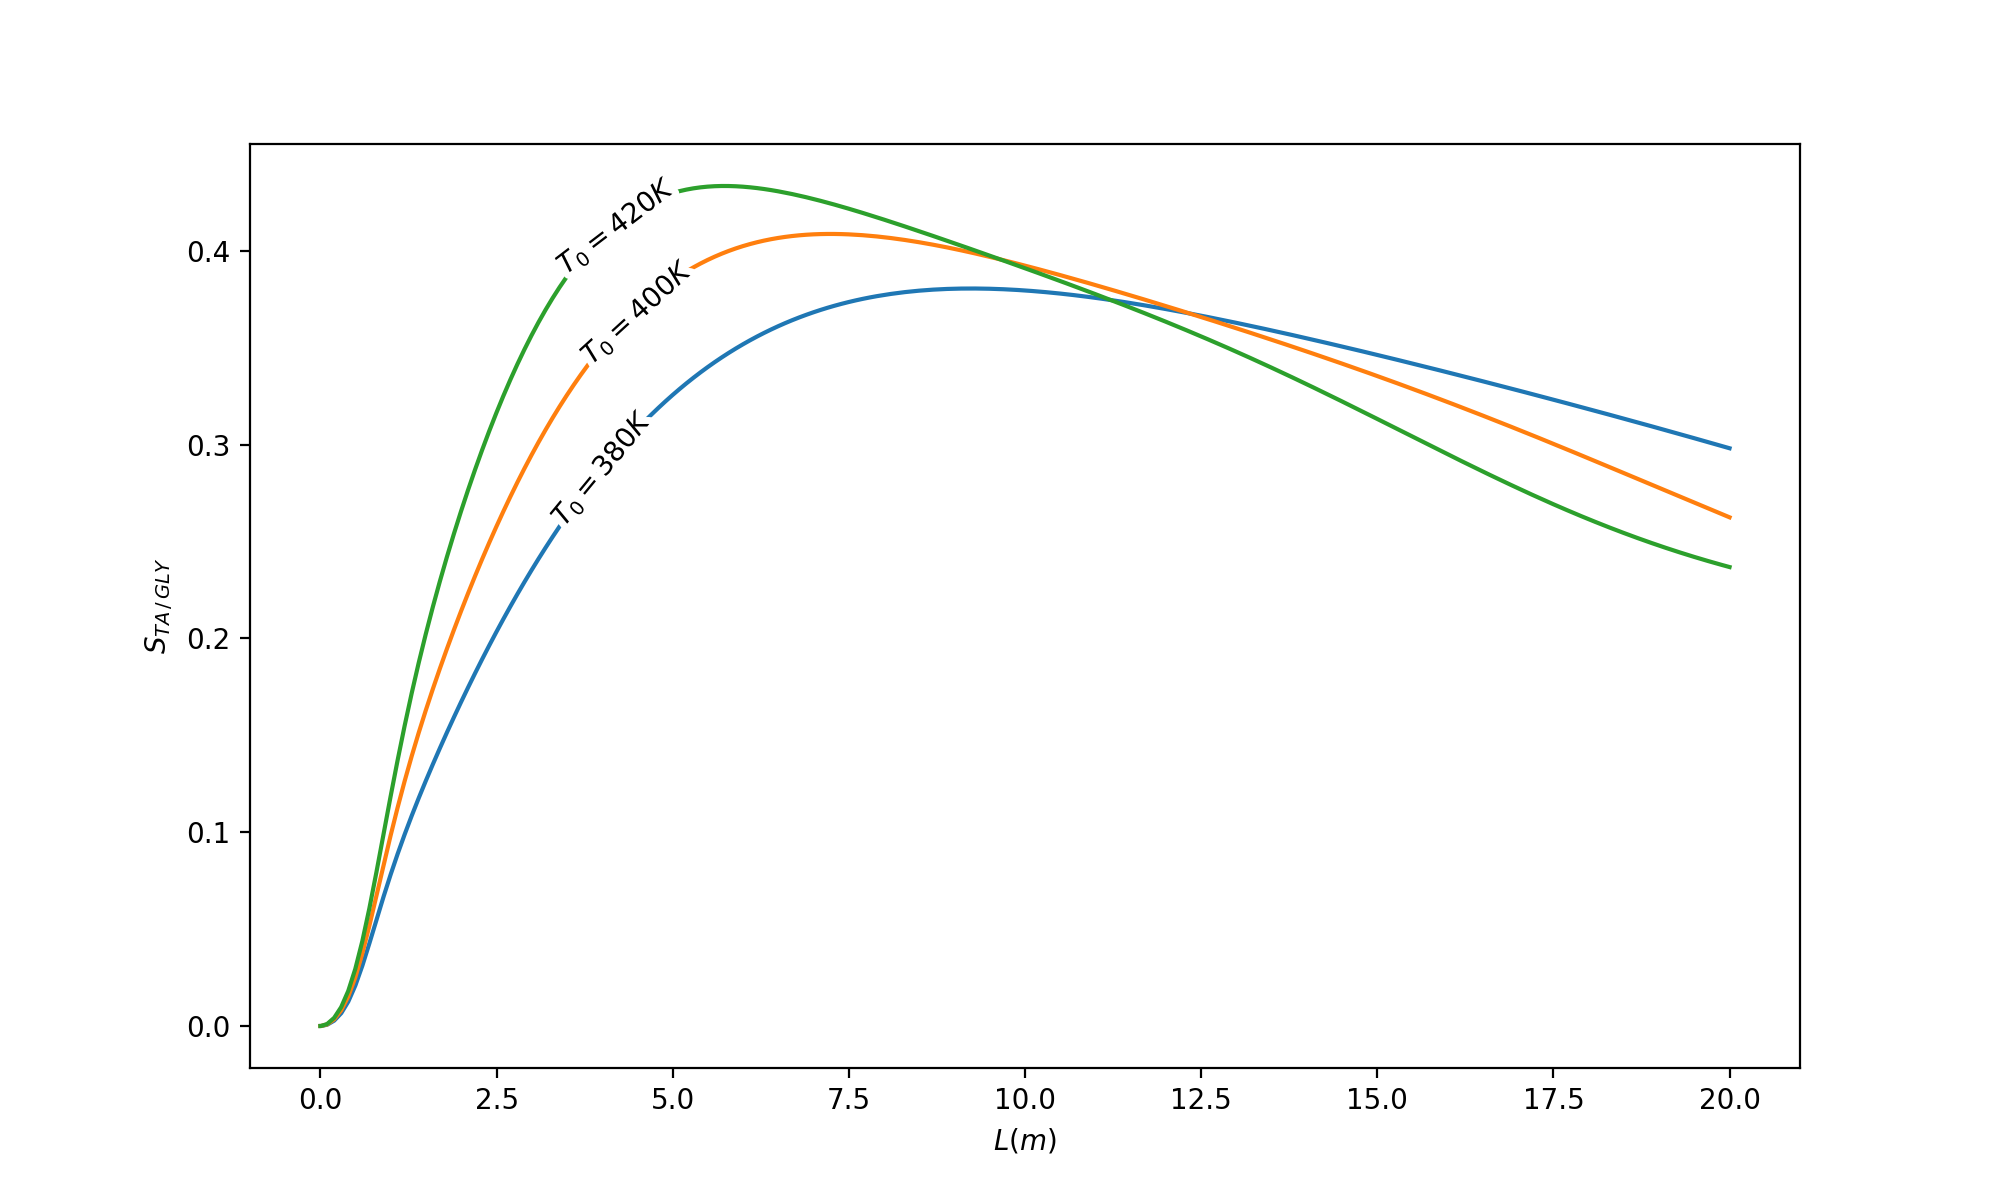

[Text(4.0, 0.2875740950599162, '$T_0=380K$'),
 Text(4.5, 0.36803507370358496, '$T_0=400K$'),
 Text(4.2, 0.4124804165269245, '$T_0=420K$')]

In [131]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

sTIW380 = r380["Triacetin"] / r380["Water"]
sTIW400 = r400["Triacetin"] / r400["Water"]
sTIW420 = r420["Triacetin"] / r420["Water"]

ax.set_ylabel("$S_{TA\,/\,GLY}$")
ax.set_xlabel("$L(m)$")
sTIW380.plot(ax=ax, legend=False, label="$T_0=380K$")
sTIW400.plot(ax=ax, legend=False, label="$T_0=400K$")
sTIW420.plot(ax=ax, legend=False, label="$T_0=420K$")
labelLines(ax.get_lines(), xvals=[4, 4.5, 4.2], yoffsets=[0, -0.002, -0.002], color="k")

<IPython.core.display.Javascript object>


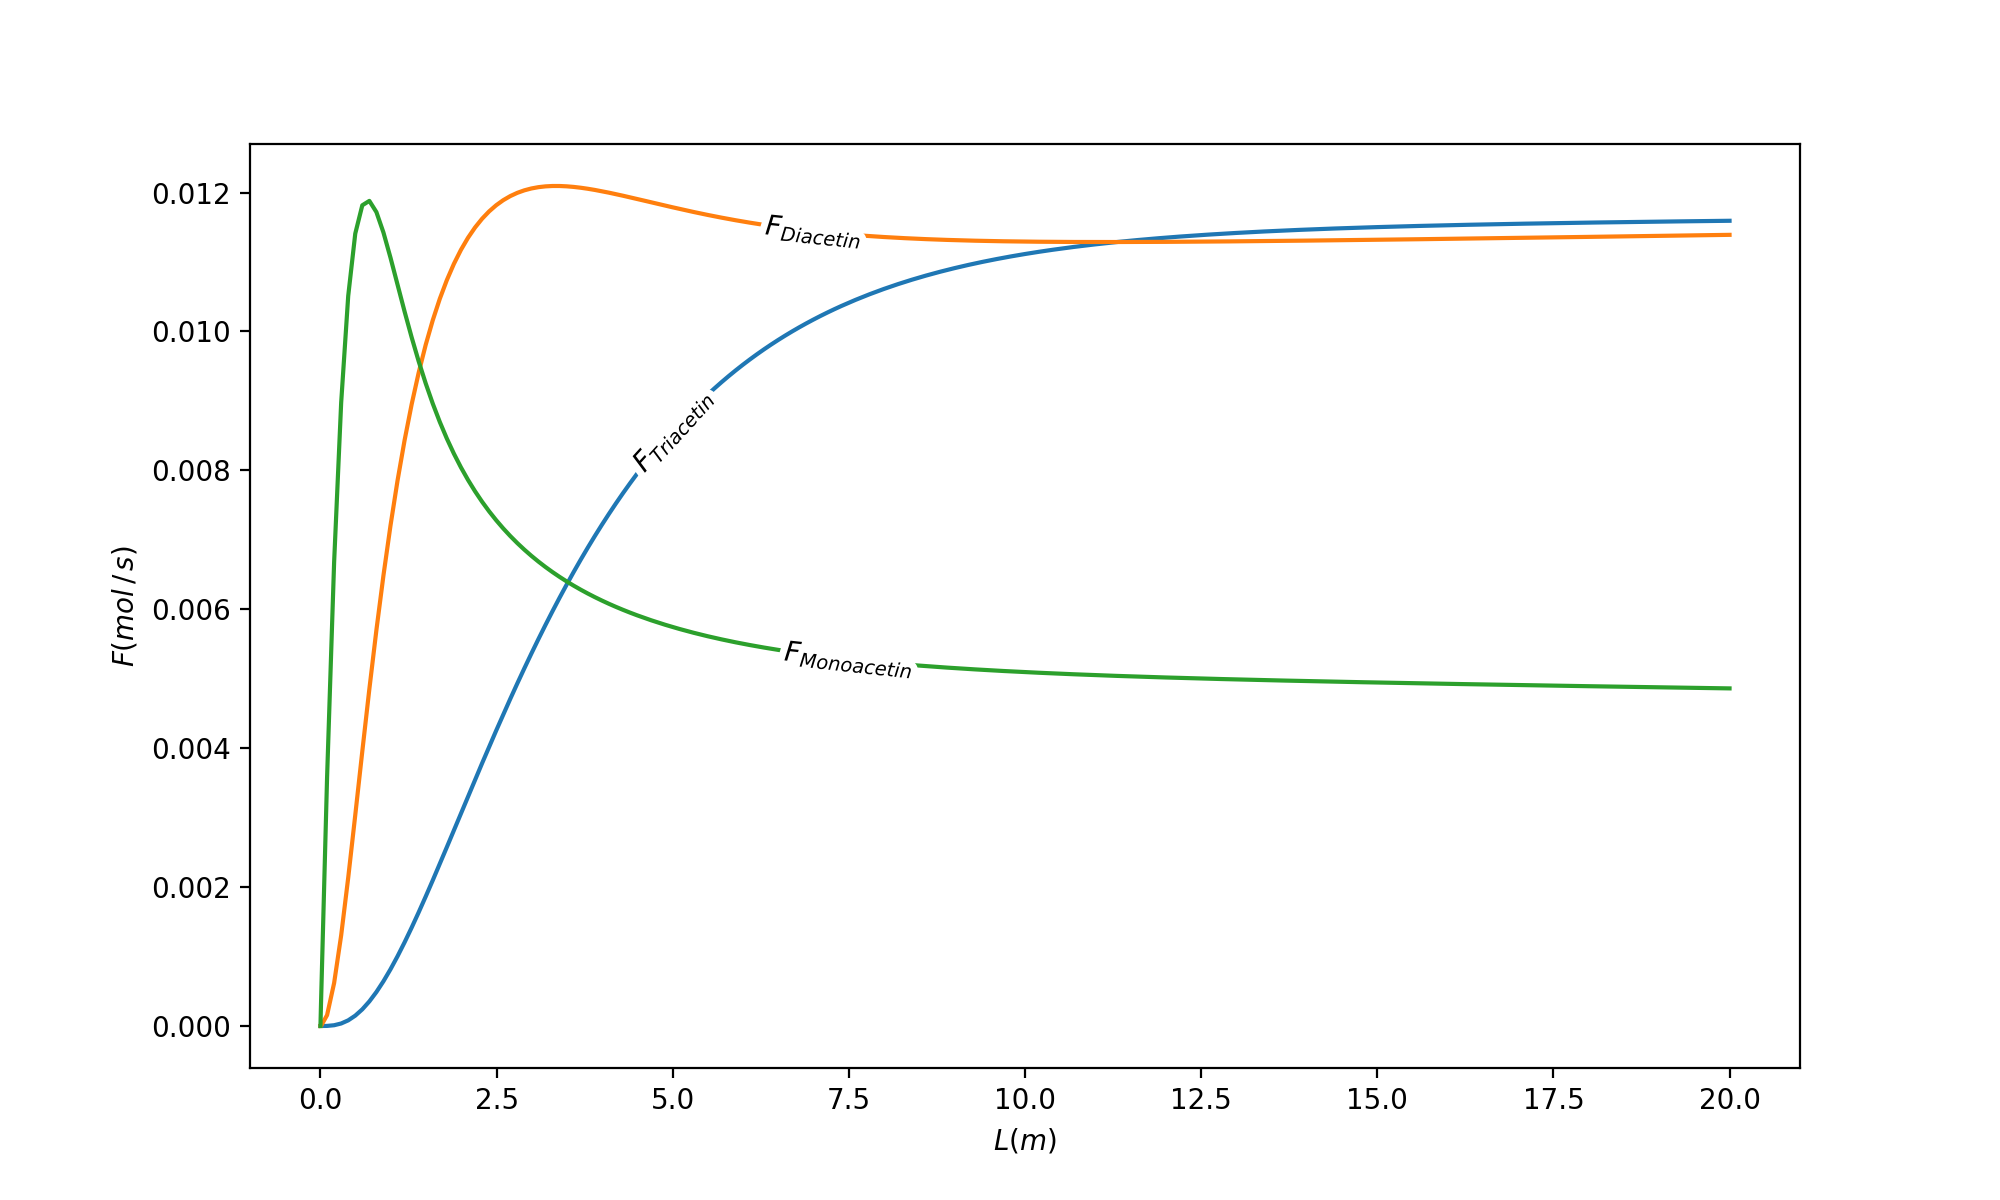

[Text(5.0, 0.008577900178902944, '$F_{Triacetin}$'),
 Text(7.0, 0.011443170023481235, '$F_{Diacetin}$'),
 Text(7.5, 0.00528203256678473, '$F_{Monoacetin}$')]

In [130]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

F380I = F380[["Triacetin", "Diacetin", "Monoacetin"]]
F400I = F400[["Triacetin", "Diacetin", "Monoacetin"]]
F420I = F420[["Triacetin", "Diacetin", "Monoacetin"]]

_color_map = {
    "Triacetin": (0.3, 0.5, 0.6),
    "Diacetin": (0.4, 0.3, 0.4),
    "Monoacetin": (0.6, 0.2, 0.9)
}

ax.set_ylabel("$F(mol\,/\,s)$")
ax.set_xlabel("$L(m)$")

# for i, column in enumerate(F380I.columns):
#     color = tuple(np.array(_color_map[column]) * (1 + i * 0.03))
#     F380I[column].plot(ax=ax, legend=False, label=f"{column} $T_0=380$", style="-", color=color)
    
# for i, column in enumerate(F400I.columns):
#    color = tuple(np.array(_color_map[column]) * (1 + i * 0.03))
#     F400I[column].plot(ax=ax, legend=False, label=f"{column} $T_0=400$", style="-", color=color)    
    
# for i, column in enumerate(F420I.columns):
#     color = tuple(np.array(_color_map[column]) * (1 + i * 0.03))
#     F420I[column].plot(ax=ax, legend=False, label=f"{column} $T_0=420$", style="-", color=color)  

for column in F420I.columns:
    F420I[column].plot(ax=ax, legend=False, label=f"$F_{{{column}}}$", style="-")     

# labelLines(ax.get_lines(), xvals=[6.3, 6.5, 15, 5.4, 6.6, 15, 4.7, 6.7, 15], fontsize=6)
labelLines(ax.get_lines(), xvals=[5, 7, 7.5], color="k")

In [11]:
yTIAA380 = F380.iloc[-1]["Triacetin"] / (F380.iloc[0]["Glycerol"] - F380.iloc[-1]["Glycerol"])
yTIAA400 = F400.iloc[-1]["Triacetin"] / (F400.iloc[0]["Glycerol"] - F400.iloc[-1]["Glycerol"])
yTIAA420 = F420.iloc[-1]["Triacetin"] / (F420.iloc[0]["Glycerol"] - F420.iloc[-1]["Glycerol"])

y = DataFrame([[yTIAA380, yTIAA400, yTIAA420]], index=["Y TI/AA"], columns=["To = 380", "To = 400", "To = 420"])
y

,To = 380,To = 400,To = 420
Y TI/AA,0.429092,0.429399,0.416355


In [120]:
yearly_production = 10000 * 1000 # kg / y
production = yearly_production * (1 / 365)  * (1 / 24) * (1 / 3600)
production = production * 1000 / substance_data["MW(g/mol)"]["Triacetin"]
production

1.4532183881115135

In [137]:
production_g = F420.iloc[-1]["Triacetin"] * substance_data["MW(g/mol)"]["Triacetin"]
production_g

2.529809783667652

In [136]:
n_tubes = production / F420.iloc[-1]["Triacetin"]
n_tubes

125.34457012729456